In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/hdd/aouadt/these/projets/3d_segm


In [2]:
from typing import Tuple
from time import time
import random
from abc import ABC, abstractmethod
from pathlib import Path

from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import convolve
import skimage.morphology as morp
import cv2
from tqdm.notebook import tqdm

from deep_morpho.models.bimonn_axspa import BimonnAxspaFromSegm
from general.utils import set_borders_to
from deep_morpho.datasets.spalike_generator import SpaLike
from deep_morpho.datasets import DataModule, SpalikeSegmEnum
from deep_morpho.models import GenericLightningModel, BinaryNN

from deep_morpho.datasets.utils import (
    rand_shape_2d,
    invert_proba,
    get_rect_vertices,
    draw_poly,
    draw_ellipse
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


# Model

In [7]:
# model = BimonnAxspaPipeline()
model = BimonnAxspaFromSegm(bimonn_channels=[7, 7], bimonn_kernel_size=[7, 7, 7])

img = torch.rand(4, 1, 256, 256)
segm = torch.randint(0, 2, size=(4, 2, 256, 256)).float()
otp = model((img, segm))

/hdd/aouadt/these/projets/3d_segm/deep_morpho/models/bisel.py:21: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  m = x // div1


In [9]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

bimonn.layers.0.bises.activation_threshold_layer.P_ torch.Size([14])
bimonn.layers.0.bises.bias_handler.param torch.Size([14])
bimonn.layers.0.bises.weights_handler.param torch.Size([14, 1, 7, 7])
bimonn.layers.0.luis.activation_threshold_layer.P_ torch.Size([7])
bimonn.layers.0.luis.bias_handler.param torch.Size([7])
bimonn.layers.0.luis.weights_handler.param torch.Size([7, 2, 1, 1])
bimonn.layers.1.bises.activation_threshold_layer.P_ torch.Size([49])
bimonn.layers.1.bises.bias_handler.param torch.Size([49])
bimonn.layers.1.bises.weights_handler.param torch.Size([49, 1, 7, 7])
bimonn.layers.1.luis.activation_threshold_layer.P_ torch.Size([7])
bimonn.layers.1.luis.bias_handler.param torch.Size([7])
bimonn.layers.1.luis.weights_handler.param torch.Size([7, 7, 1, 1])
bimonn.layers.2.bises.activation_threshold_layer.P_ torch.Size([7])
bimonn.layers.2.bises.bias_handler.param torch.Size([7])
bimonn.layers.2.bises.weights_handler.param torch.Size([7, 1, 7, 7])
bimonn.layers.2.luis.activatio

# Dataset and Dataloader

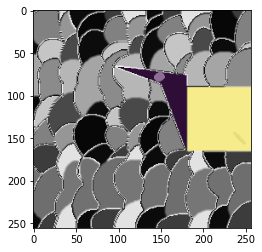

In [52]:
dataset = DataModule.select("spalikedataset")(
    image_size=(256, 256),
    segm_mode=SpalikeSegmEnum.BonesSeparated,
)
(img, segm), label = dataset[0]
segm.shape

segm_ = np.where(segm[0].numpy() == 1, segm[0], segm[1]*2)

plt.imshow(img[0], cmap="gray")
plt.imshow(np.ma.masked_where(segm_ == 0, segm_), alpha=.5)

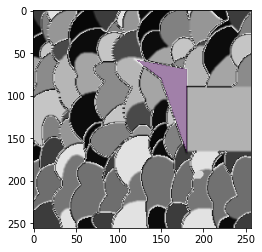

In [45]:
dataset = DataModule.select("spalikedataset")(
    image_size=(256, 256),
    # segm_mode=SpalikeSegmMode.BonesOverlapped,
    segm_mode=SpalikeSegmEnum.Roi,
)
(img, segm), label = dataset[0]
segm.shape

plt.imshow(img[0], cmap="gray")
plt.imshow(np.ma.masked_where(segm[0] == 0, segm[0]), alpha=.5)

Text(0.5, 1.0, '0.0')

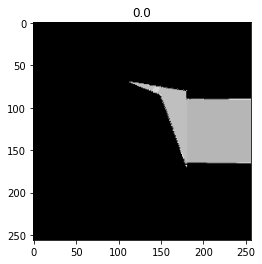

In [42]:
dataset = DataModule.select("spalikedatasetmerged")(
    image_size=(256, 256),
    segm_mode=(
        SpalikeSegmEnum.BonesOverlapped
        # SpalikeSegmMode.Roi
        # SpalikeSegmMode.BonesSeparated
        # SpalikeSegmMode.NoSegm
    ),
)
img, label = dataset[0]


plt.imshow(img[0], cmap="gray")
plt.title(label.item())

In [15]:
model = BinaryNN.select("ConvSpalikeMerged")(
    channels=[256, 256],
    kernel_size=[3, 3, 3],
    classif_neurons=[64]
)

dataloader = DataModule.select("spalikedataset").get_loader(
    n_inputs=100, batch_size=4,
    image_size=(256, 256),
    segm_mode=(
        SpalikeSegmEnum.BonesOverlapped
        # SpalikeSegmMode.Roi
        # SpalikeSegmMode.BonesSeparated
        # SpalikeSegmMode.NoSegm
    ),
    merge_input_segm=True,
)
imgs, labels = next(iter(dataloader))
model(imgs)


# plt.imshow(img[0], cmap="gray")


tensor([[0.3335],
        [0.8181],
        [0.6189],
        [0.6725]], grad_fn=<AddmmBackward0>)

In [7]:
dataloader = DataModule.select("spalikedataset").get_loader(image_size=(256, 256), n_inputs=10000, batch_size=24, num_workers=24)

pbar = tqdm(dataloader, total=len(dataloader))
for batch in dataloader:
    pbar.update(1)

  0%|          | 0/417 [00:00<?, ?it/s]

In [12]:
dataloader = DataModule.select("spalikedataset").get_loader(image_size=(256, 256), n_inputs=10000, batch_size=24, num_workers=24)
model = BimonnAxspaFromSegm(bimonn_channels=[7, 7], bimonn_kernel_size=[7, 7, 7])

model.to(device)

pbar = tqdm(dataloader, total=len(dataloader))
for batch in dataloader:
    (img, segm), label = batch
    img = img.to(device)
    segm = segm.to(device)
    otp = model((img, segm))
    pbar.update(1)

  0%|          | 0/417 [00:00<?, ?it/s]

KeyboardInterrupt: 

/hdd/aouadt/these/projets/3d_segm/deep_morpho/models/bisel.py:21: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  m = x // div1


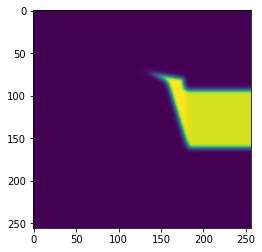

In [14]:
otps = model.bimonn(segm)
plt.imshow(otps[0, 0].cpu().detach().numpy())

In [11]:
segm.shape

torch.Size([24, 2, 256, 256])

In [3]:
dataloader = DataModule.select("spalikedataset").get_loader(image_size=(256, 256), n_inputs=10000, batch_size=24, num_workers=24)
model = GenericLightningModel.select("LightningBimonnAxspaFromSegm")(
    model_args={
        "bimonn_channels": [7, 7], "bimonn_kernel_size": [7, 7, 7]
    },
    learning_rate=1e-3,
    loss=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.Adam,
)

model.to(device)

pbar = tqdm(dataloader, total=len(dataloader))
for batch in dataloader:
    (img, segm), label = batch
    img = img.to(device)
    segm = segm.to(device)
    label = label.to(device)
    otp = model((img, segm))
    loss = model.loss(otp, label)
    loss.backward()
    model.optimizer.step()
    pbar.update(1)
    assert False

  0%|          | 0/417 [00:00<?, ?it/s]

/hdd/aouadt/these/projets/3d_segm/deep_morpho/models/bisel.py:21: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  m = x // div1


TypeError: step() missing 1 required positional argument: 'self'

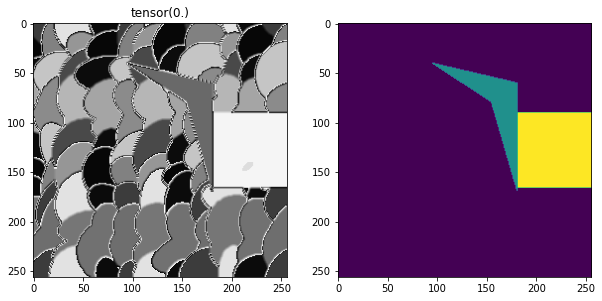

In [44]:
img, segm, tar = next(iter(dataloader))

img = img[0].numpy()
segm = segm[0].permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img, cmap="gray")
plt.title(tar[0])

plt.subplot(122)
to_plot = np.zeros((segm.shape[0], segm.shape[1]))
to_plot[segm[:, :, 0].astype(bool)] = 1
to_plot[segm[:, :, 1].astype(bool)] = 2
plt.imshow(to_plot)

# Results Analysis

In [36]:
# tb_path = "deep_morpho/results/results_tensorboards/Bimonn_exp_82/sandbox/0_/3/spalike/bimonnaxspafromsegm/version_0"
# tb_path = "deep_morpho/results/results_tensorboards/Bimonn_exp_82/sandbox/0_/7/spalike/bimonnaxspafromsegm/version_0"
tb_path = "deep_morpho/results/results_tensorboards/test/3/spalike/bimonnaxspafromsegm/version_0/"




tb_path = Path(tb_path)
# list((Path(tb_path) / "best_weights").iterdir())

loss = nn.BCEWithLogitsLoss()

for path_weights in (Path(tb_path) / "best_weights").iterdir():
    if "epoch" in path_weights.name:
        break
    # if "last" in path_weights.name:
    #     break 

path_weights = "todelete/val"
print(path_weights)
model = GenericLightningModel.load_from_checkpoint(path_weights, loss=loss)

todelete/val


In [26]:
x = torch.randint(0, 2, (1, 2, 256, 256)).float().to(device)

model.model.bimonn(x)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument weight in method wrapper___conv_depthwise2d)

In [42]:
batch_size = 64

class DummyArgs(dict):
    def __init__(self):
        self["n_inputs.train"] = 100 * batch_size
        self["n_inputs.val"] = 10 * batch_size
        self["n_inputs.test"] = 10 * batch_size
        self["batch_size"] = batch_size
        self["num_workers"] = 24
        self.trainset_args_suffix = ".train"
        self.valset_args_suffix = ".val"
        self.testset_args_suffix = ".test"

    def trainset_args(self):
        return self.dataset_args()
    
    def valset_args(self):
        return self.dataset_args()
    
    def testset_args(self):
        return self.dataset_args()
    
    def dataset_args(self):
        return {
            "image_size": (256, 256),
            "proba_lesion": 0.5,
            "proba_lesion_locations": {
                "sacrum": 0.4,
                "iliac": 0.4,
            },
            "grid_spacing": (24, 24),
            "min_ellipse_axes": 13,
            "max_ellipse_axes": 35,
            "period": (3, 10),
            "offset": (1, 2),
            "min_output_ellipse": 0,
            "max_n_blob": 5,
        }


class DummyExperiment:
    args = DummyArgs()

experiment = DummyExperiment()
trainloader, valloader, testloader = DataModule.select("spalikedataset").get_train_val_test_loader_from_experiment(experiment)


In [41]:
model.model.binary(True)

BimonnAxspaFromSegm(
  (bimonn): BiMoNN(
    (layers): BinarySequential(
      (0): BiSEL(
        (bises): BiSE(
          (conv): Conv2d(2, 6, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=2, bias=False, padding_mode=replicate)
          (activation_threshold_layer): TanhLayer()
          (bias_handler): BiasSoftplus(
            (softplus_layer): Softplus(beta=1, threshold=20)
          )
          (weights_handler): WeightsThresholdedBise(
            (threshold_layer): SoftplusThresholdLayer()
          )
        )
        (luis): LUI(
          (conv): Conv2d(6, 3, kernel_size=(1, 1), stride=(1, 1), groups=3, bias=False, padding_mode=replicate)
          (activation_threshold_layer): TanhLayer()
          (bias_handler): BiasBiseSoftplusReparametrized(
            (softplus_layer): Softplus(beta=1, threshold=20)
          )
          (weights_handler): WeightsThresholdedBise(
            (threshold_layer): SoftplusThresholdLayer()
          )
        )
      )
      (

In [66]:
model.to(device)


###### TRAIN SET ########
# model.train()

train_preds = []
train_labels = []

for (img, segm), label in tqdm(trainloader):
    img = img.to(device)
    segm = segm.to(device)
    label = label.to(device)

    otp = model((img, segm))
    train_preds.append(otp.detach().cpu().numpy())
    train_labels.append(label.detach().cpu().numpy())

train_preds = np.concatenate(train_preds)
train_labels = np.concatenate(train_labels)

train_acc = np.mean((train_preds > 0) == train_labels)
print(f"Train acc: {train_acc}")

###### VAL SET ########
model.eval()

val_preds = []
val_labels = []

for (img, segm), label in tqdm(valloader):
    img = img.to(device)
    segm = segm.to(device)
    label = label.to(device)

    otp = model((img, segm))
    val_preds.append(otp.detach().cpu().numpy())
    val_labels.append(label.detach().cpu().numpy())

val_preds = np.concatenate(val_preds)
val_labels = np.concatenate(val_labels)

val_acc = np.mean((val_preds > 0) == val_labels)
print(f"Val acc: {val_acc}")

###### TEST SET ########
model.eval()

test_preds = []
test_labels = []

for (img, segm), label in tqdm(testloader):
    img = img.to(device)
    segm = segm.to(device)
    label = label.to(device)

    otp = model((img, segm))
    test_preds.append(otp.detach().cpu().numpy())
    test_labels.append(label.detach().cpu().numpy())

test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

test_acc = np.mean((test_preds > 0) == test_labels)
print(f"Test acc: {test_acc}")



  0%|          | 0/100 [00:00<?, ?it/s]

Train acc: 0.52828125


  0%|          | 0/10 [00:00<?, ?it/s]

Val acc: 0.55625


  0%|          | 0/10 [00:00<?, ?it/s]

Test acc: 0.509375


In [20]:
path_batches = Path("todelete/val_1")
all_batches = sorted(list(path_batches.glob("batch_*.pt")))
print((all_batches))

[PosixPath('todelete/val_1/batch_0.pt'), PosixPath('todelete/val_1/batch_1.pt'), PosixPath('todelete/val_1/batch_2.pt'), PosixPath('todelete/val_1/batch_3.pt'), PosixPath('todelete/val_1/batch_4.pt'), PosixPath('todelete/val_1/batch_5.pt'), PosixPath('todelete/val_1/batch_6.pt'), PosixPath('todelete/val_1/batch_7.pt'), PosixPath('todelete/val_1/batch_8.pt'), PosixPath('todelete/val_1/batch_9.pt')]


In [65]:
path_batches = Path("todelete/val_2")
all_batches = sorted(list(path_batches.glob("batch_*.pt")))
all_preds = sorted(list(path_batches.glob("preds_*.pt")))
all_bimonns = sorted(list(path_batches.glob("bimonn_*.pt")))
all_current_preds = sorted(list(path_batches.glob("current_preds_*.pt")))

model = GenericLightningModel.load_from_checkpoint(path_batches / "checkpoint.pt", loss=nn.BCEWithLogitsLoss())
model.to(device)
model.eval()

val_labels = []
val_preds = []
val_first_preds = []
val_first_bimonns = []
val_first_current_preds = []
val_bimonns = []

for path_batch, path_preds, path_bimonn, path_cur_preds in tqdm(zip(all_batches, all_preds, all_bimonns, all_current_preds)):
    val_first_preds.append(torch.load(path_preds).detach().cpu().numpy())
    val_first_bimonns.append(torch.load(path_bimonn).detach().cpu().numpy())
    val_first_current_preds.append(torch.load(path_cur_preds).detach().cpu().numpy())
    
    batch = torch.load(path_batch)
    (img, segm), label = batch
    img = img.to(device)
    segm = segm.to(device)
    label = label.to(device)

    otp = model((img, segm))

    val_bimonns.append(model.model.current_output["bimonn"].detach().cpu().numpy())
    val_preds.append(otp.detach().cpu().numpy())
    val_labels.append(label.detach().cpu().numpy())

val_first_preds = np.concatenate(val_first_preds)
val_preds = np.concatenate(val_preds)
val_labels = np.concatenate(val_labels)
val_first_current_preds = np.concatenate(val_first_current_preds)

val_acc = np.mean((val_preds > 0) == val_labels)
val_acc_ini = np.mean((val_first_preds > 0) == val_labels)

print(f"Val acc: {val_acc}")
print(f"Val acc ini: {val_acc_ini}")
print(f"Val acc ini cur preds: {np.mean((val_first_current_preds > 0) == val_labels)}")

0it [00:00, ?it/s]

Val acc: 0.5078125
Val acc ini: 0.5078125
Val acc ini cur preds: 0.5078125


0.0


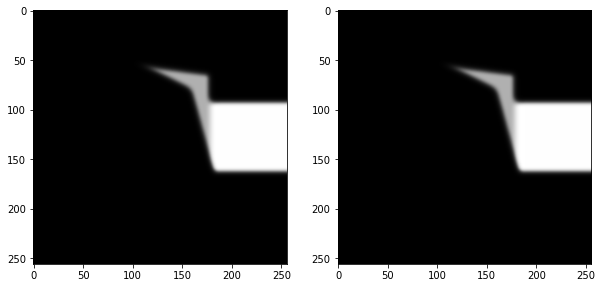

In [36]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(val_first_bimonns[0][0, 0], cmap="gray")

plt.subplot(122)
plt.imshow(val_bimonns[0][0, 0], cmap="gray")

# diff
print(np.abs(val_first_bimonns[0] - val_bimonns[0]).max())

In [12]:
len(val_labels)

640

# Spa Like Dataset

In [56]:
%%timeit
dil1 = dilate_cv(img, selem)

18.3 µs ± 52 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [57]:
%%timeit
dil1 = erode_cv(img, selem)

18.5 µs ± 141 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [54]:
%%timeit
dil1 = morp.binary_dilation(img, selem)

606 µs ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


True
150
218


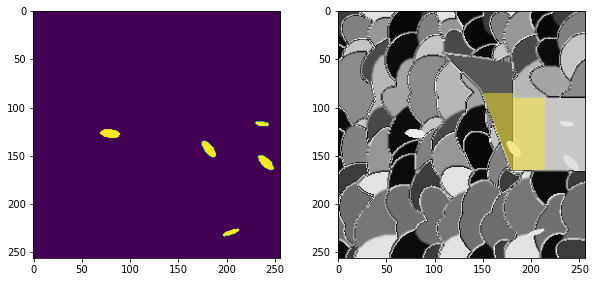

In [26]:
img = np.zeros((256, 256), dtype=np.uint8)



gen = SpaLike((256, 256), proba_lesion=0.5, max_n_blob_sane=5, grid_spacing=(24, 24), max_ellipse_axes=35)
img, segm = gen.generate_image()
roi = gen.roi

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(gen.segmentation_lesion, )

plt.subplot(222)
plt.imshow(img, vmin=0, vmax=255, cmap="gray")
# draw bbox
# (xmin, ymin), (xmax, ymax) = bone_gen.iliac_bbox1
# plt.plot([xmin, xmin, xmax, xmax, xmin], [ymin, ymax, ymax, ymin, ymin], color="red")
# draw roi on a masked plot using masked array
plt.imshow(np.ma.masked_where(roi == 0, roi), vmin=0, vmax=1, alpha=0.5)

print(gen.label)

# plt.subplot(223)
# plt.imshow(gen.zones_init[0])

# plt.subplot(224)
# plt.imshow(gen.zones[0])

print((roi & gen.segmentation_lesion).sum())
print(((~roi & ~gen.iliac_segmentation & ~gen.sacrum_segmentation) & gen.segmentation_lesion).sum())


In [27]:
%%timeit
img, segm = gen.generate_image()


n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 3
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
n_try: 2
4.67 ms ± 246 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
gen.texture_generator.grid_spacing

(16, 16)

In [4]:
from deep_morpho.datasets import DiskorectDataset
from deep_morpho.morp_operations import ParallelMorpOperations

disko = DiskorectDataset(morp_operation=ParallelMorpOperations.closing(selem=morp.disk(3)))

In [5]:
%%timeit
disko[0]

1.68 ms ± 34.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [126]:
segm_sac = gen.sacrum_segmentation
segm_ili = gen.iliac_segmentation

(xmin, ymin), (xmax, ymax) = gen.bone_generator.iliac_bbox1
selem_left = np.zeros((1, 2*(ymax - ymin)))
selem_left[0, :ymax - ymin] = 1
dil_sac = morp.binary_dilation(segm_sac, selem_left)
dil_ili = morp.binary_dilation(segm_ili, selem_left[:, ::-1])

ili_roi = dil_sac & segm_ili
ili_roi = morp.binary_dilation(ili_roi, morp.disk(3)) & segm_ili

sac_roi = dil_ili & segm_sac

final_roi = ili_roi | sac_roi

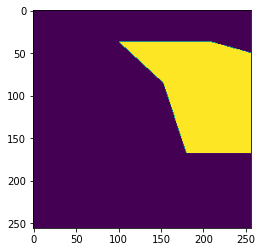

In [127]:
plt.imshow(dil_ili)

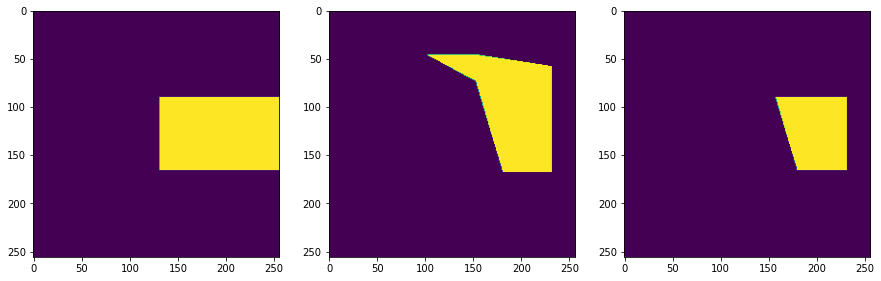

In [25]:
sac = bone_gen.sacrum_segmentation
ili = bone_gen.iliac_segmentation

selem_right = np.array([[0, 1, 1]])
selem_left = np.array([[1, 1, 0]])

def dilate_right(img: np.ndarray, n: int = 1) -> np.ndarray:
    for _ in range(n):
        img = morp.dilation(img, selem_right)
    return img

def dilate_left(img: np.ndarray, n: int = 1) -> np.ndarray:
    for _ in range(n):
        img = morp.dilation(img, selem_left)
    return img

dil_sac = dilate_right(sac, 50)
dil_ili = dilate_left(ili, 50)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(dil_sac)

plt.subplot(132)
plt.imshow(dil_ili)
# plt.imshow(ili)

plt.subplot(133)
plt.imshow(dil_sac * dil_ili)

In [265]:
import cv2
import numpy as np
import random

# Set parameters for your toy dataset
image_size = (256, 256)  # Adjust the size as needed
triangle_size = (32, 32)  # Size of the triangle representing the joint
num_samples = 100  # Number of samples
grid_spacing = 16  # Spacing between ellipses
num_ellipses = 100  # Number of random ellipses
min_ellipse_axes = 13  # Minimum size of ellipse axes
max_ellipse_axes = 18  # Maximum size of ellipse axes
num_colors = 3  # Number of random colors for ellipses


# sinusoidal grid
def sin_grid(x, y, period=(1, 1), offset=(0, 0)):
    def f(x, p):
        return (np.sin(x * 2 * np.pi / p) + 1) / 2 + 1
    return f(x - offset[0], period[0]) * f(y - offset[1], period[1]) + 3


def normalize(x, minv, maxv, min_output_value=0):
    # print(maxv, minv)
    return (x - minv) / (maxv - minv) * (255 - min_output_value) + min_output_value

def generate_synthetic_image(period, offset=(1, 2)):
    # Create a blank image with a grid of ellipses as texture
    background = np.zeros((image_size[0], image_size[1]), dtype=np.uint8)
    
    # Define the position of the triangle within the image
    x = random.randint(0, image_size[0] - triangle_size[0])
    y = random.randint(0, image_size[1] - triangle_size[1])

    # Draw a triangle to represent the joint
    triangle_color = (255, 255, 255)  # White triangle
    triangle = np.array([[x, y], [x + triangle_size[0], y], [x + triangle_size[0] // 2, y + triangle_size[1]]], np.int32)

    # Add information for classification within the triangle
    classification_info = random.choice([0, 1])  # 0 for no inflammation, 1 for inflammation

    # Randomly generate ellipses with different shapes and colors in a grid
    Xs = np.linspace(0, image_size[0], num=int(image_size[0] / grid_spacing) + 1, dtype=np.int32)
    Ys = np.linspace(0, image_size[1], num=int(image_size[1] / grid_spacing) + 1, dtype=np.int32)
    
    # values = sin_grid(np.array(image_size) + 1)

    for idx_x, center_x in enumerate(Xs):
        for idx_y, center_y in enumerate(Ys):
            ellipse_axes = (random.randint(min_ellipse_axes, max_ellipse_axes), random.randint(min_ellipse_axes, max_ellipse_axes))
            angle = random.uniform(0, 360)  # Random rotation angle
            # ellipse_color = random.randint(0, 255)
            ellipse_color = normalize(sin_grid(idx_x + 1, idx_y + 1, period=period, offset=offset), minv=3, maxv=7)
            
            # Draw the random ellipse
            cv2.ellipse(background, (center_x, center_y), ellipse_axes, angle, 0, 360, ellipse_color, -1)

    triangle = np.array([[x, y], [x + triangle_size[0], y], [x + triangle_size[0] // 2, y + triangle_size[1]]], np.int32)
    cv2.fillPoly(background, [triangle], random.randint(64, 170))
    return background, classification_info

4.809161060780646
5.25
5.690838939219354
5.963292387221365
5.963292387221365
5.690838939219355
5.25
4.809161060780646
4.536707612778635
4.536707612778635
4.809161060780645
5.25
5.690838939219354
5.963292387221365
5.963292387221365
5.690838939219355
5.25
5.331420873505193
5.899519052838329
6.467617232171466
6.818721215946278
6.818721215946278
6.467617232171467
5.899519052838329
5.331420873505193
4.980316889730381
4.980316889730381
5.331420873505192
5.899519052838329
6.467617232171465
6.818721215946278
6.818721215946278
6.467617232171467
5.899519052838329
4.286901248056099
4.600480947161671
4.914060646267244
5.107863558496454
5.107863558496454
4.914060646267244
4.600480947161671
4.286901248056099
4.093098335826889
4.093098335826889
4.286901248056098
4.600480947161671
4.914060646267243
5.107863558496454
5.107863558496454
4.914060646267244
4.600480947161671
4.809161060780646
5.25
5.690838939219354
5.963292387221365
5.963292387221365
5.690838939219355
5.25
4.809161060780646
4.53670761277863

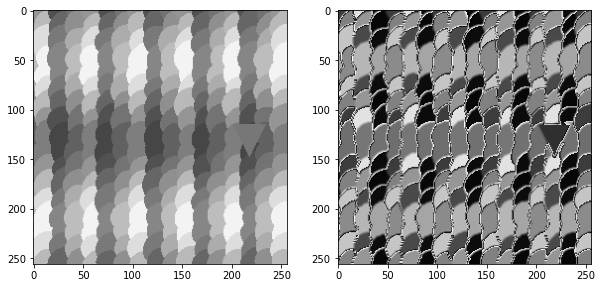

In [266]:
img, label = generate_synthetic_image(period=(3, 10))
# img += np.random.randint(0, 10, img.shape, dtype=np.uint8)
# img, label = generate_synthetic_image(period=(10, 3))
# convolve the img
fimg = convolve(img, np.ones((3, 3)))
# fimg = convolve(img, morp.disk(3))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img, vmin=0, vmax=255, cmap="gray")

plt.subplot(122)
plt.imshow(fimg, vmin=0, vmax=255, cmap="gray")

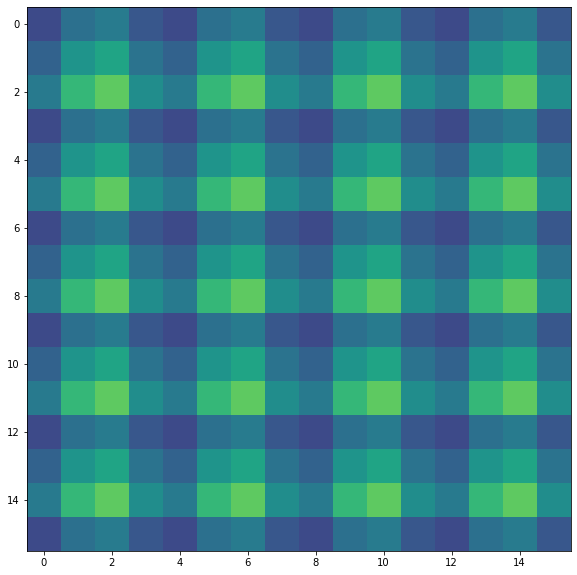

In [166]:
# sinusoidal grid
def sin_grid(x, y, period=(1, 1), offset=(0, 0)):
    def f(x, p):
        return (np.sin(x * 2 * np.pi / p) + 1) / 2 + 1
    return f(x - offset[0], period[0]) * f(y - offset[1], period[1])

XX, YY = np.meshgrid(np.arange(16), np.arange(16))
ZZ = sin_grid(XX, YY, period=(4, 3), offset=[.7, 1])

plt.figure(figsize=(10, 10))
plt.imshow(ZZ, vmin=0, vmax=5,)


In [231]:
%%timeit 
img, label = generate_synthetic_image()


2.96 ms ± 16 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
x.shape
torch.Size([1, 1, 256, 256])
x.shape
torch.Size([1, 64, 128, 128])
x.shape
torch.Size([1, 64, 128, 128])
x.shape
torch.Size([1, 64, 64, 64])
x.shape
torch.Size([1, 64, 64, 64])
x.shape
torch.Size([1, 128, 32, 32])
x.shape
torch.Size([1, 256, 16, 16])
x.shape
torch.Size([1, 512, 8, 8])